# Cross-resonance gate between two transmons and a spectator.

In this notebook we study the cross-resonance two-qubit gate between two transmons and a third spectator transmon. 

In [214]:
import time
from collections import defaultdict
from itertools import product, combinations
from typing import List, Dict, Callable, Optional
import pathlib
import copy
import json
import math
import cmath

import numpy as np
import xarray as xr
import scipy.integrate
import qutip as qtp
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from pysqkit import qubits, systems, couplers, drives, solvers, util
from util_tt_cr import single_qubit_corrections

import pysqkit.util.transformations as trf
from pysqkit.drives.pulse_shapes import gaussian_top
from pysqkit.util.metrics import average_process_fidelity, average_gate_fidelity
from pysqkit.util.phys import temperature_to_thermalenergy
from pysqkit.util.quantum import generalized_rabi_frequency
from pysqkit.util.linalg import get_mat_elem
from pysqkit.util.hsbasis import weyl_by_index
from pysqkit.tomography import TomoEnv

from pysqkit.solvers.solvkit import integrate
from pysqkit.solvers import solvkit

from IPython.display import display, Latex

In [215]:
SOLVER_OPTIONS = qtp.solver.Options()
SOLVER_OPTIONS.atol = 1e-12
SOLVER_OPTIONS.rtol = 1e-10

In [216]:
TEX_RC_PARAMS = {
    'backend': 'ps',
    'text.latex.preamble': [r'\usepackage{gensymb}'],
    'axes.labelsize': 10,
    'legend.fontsize': 10,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
    'font.family': 'serif'
}

# Define auxillary functions used

In [217]:
def comp_state_labels(num_qubits: Optional[int] = 2):
    state_combinations = product("01", repeat=num_qubits)
    labels = ["".join(states) for states in state_combinations]
    return labels

def state_labels(*qubit_states):
    state_combinations = product(*qubit_states)
    labels = ["".join(states) for states in state_combinations]
    return labels

def get_states(system, state_labels):
    states = {}
    for label in state_labels:
        _state = system.state(label)[1]
        
        loc = np.argmax(np.abs(_state))
        phase = cmath.phase(_state[loc])
        
        states[label] = np.exp(-1j*phase) * _state
    return states

In [218]:
def extract_freqs(
    qubit: systems.Qubit, 
) -> Dict[str, float]:
    """
    Description
    --------------------------------------------------------------
    Returns the transition frequencies of a given qubit.
    """
    
    num_levels = qubit.dim_hilbert
    
    results = {}
    
    states = [qubit.state(str(level)) for level in range(num_levels)]
        
    for level_i, level_j in combinations(range(num_levels), 2):
        freq_i = states[level_i][0]
        freq_j = states[level_j][0]
        results[f"freq_{level_i}{level_j}"] = freq_j - freq_i

    return results

In [219]:
def zz_crosstalk(system: systems.QubitSystem) -> float:
    xi_zz = system.state('00')[0] + system.state('11')[0] \
        - system.state('01')[0] - system.state('10')[0]
    return xi_zz

def xz_coeff(comp_states, op) -> float:
    xz0 = get_mat_elem(op, comp_states['00'], comp_states['10'])
    xz1 = get_mat_elem(op, comp_states['01'], comp_states['11'] )
    return (np.imag(xz0 - xz1))/2

def xi_coeff(comp_states, op) -> float:
    xi0 = get_mat_elem(op, comp_states['00'], comp_states['10'] )
    xi1 = get_mat_elem(op, comp_states['01'], comp_states['11'] )
    return (np.imag(xi0 + xi1))/2

In [220]:
def func_to_minimize(
    x: List[float],
    rise_time: float,
    amp: float
) -> float:
    pulse_time = x[0]
    time_step = 1e-3
    num_points = int(pulse_time/time_step)
    times = np.linspace(0, pulse_time, num_points)
    
    pulse = gaussian_top(times, rise_time, pulse_time)
    integral = scipy.integrate.simpson(2*np.pi*amp*pulse, times)
    return np.abs(integral - np.pi/4)  #Watch out factor of 2?  

In [221]:
def minimize_drive_time(
    system: systems.QubitSystem,
    comp_states: List[np.ndarray],
    eps_drive : float,
    rise_time : Optional[float] = 5.0,
    *,
    init_time : Optional[float] = 100.0,
) -> float:
    
    q_op = system["control"].charge_op()
    args_to_pass = (rise_time, np.abs(xz_coeff(comp_states, q_op))*0.5*eps_drive)

    try:
        minimization_result = minimize(
            func_to_minimize, 
            init_time,
            args=args_to_pass
        )
        gate_time = minimization_result['x'][0]
    except ValueError:
        gate_time = None
    
    return gate_time

def get_drive_params(
    system: systems.QubitSystem,
    comp_states: List[np.ndarray],
    eps_drive : float,
    rise_time : Optional[float] = 10.0,
    *,
    init_time : Optional[float] = 100.0,
    detuning : Optional[float] = 0,
    points_per_period : Optional[int] = 10
):
    pulse_time = minimize_drive_time(
        system = coupled_sys,
        comp_states = comp_states,
        eps_drive = eps_drive,
        rise_time = rise_time,
        init_time=init_time
    )
    
    if pulse_time is None:
        raise ValueError("Pulse time minimization has failed.") # Should be handled differently
    
    drive_freq = system["target"].freq
    
    num_points = int(pulse_time * drive_freq * points_per_period)
    times = np.linspace(0, pulse_time, num_points)

    params = dict(
        phase = 0, 
        time = times, 
        rise_time = rise_time, 
        pulse_time = pulse_time,
        amp = eps_drive, 
        freq = drive_freq + detuning
    )
    return params

In [222]:
def run_simulation(
    times: np.ndarray,
    system: systems.QubitSystem, 
    init_state: qtp.qobj.Qobj, 
    options: Optional[qtp.solver.Options] = None,
    *,
    solver="mesolve",
    with_noise: Optional[bool] = False
) -> qtp.solver.Result:
    sys_hamil = system.hamiltonian(as_qobj=True)
    drive_hamils = []
    drive_pulses = []
                    
    for qubit in system:
        if qubit.is_driven:
            for label, drive in qubit.drives.items():
                drive_hamils.append(drive.hamiltonian(as_qobj=True))
                drive_pulses.append(drive.eval_pulse())
    
    if with_noise:
        jump_ops = [op for qubit in system for op in qubit.collapse_ops(as_qobj=True)]
    else:
        jump_ops = []
                    
    result = integrate(
        times, 
        init_state, 
        sys_hamil, 
        drive_hamils,
        drive_pulses, 
        jump_ops, 
        solver=solver, 
        options=options
    )
                    
    return result  

In [223]:
def get_probabilities(
    state_labels : List[str], 
    system : systems.QubitSystem, 
    output_states : List[qtp.Qobj],
) -> Dict:
    probs_dict = {}
    
    for label in state_labels:
        probs = []
        
        state = system.state(label, as_qobj=True)[1]        
        projector = state*state.dag()
        
        for out_state in output_states:
            prob = qtp.expect(projector, out_state)
            probs.append(prob)
        
        probs_dict[label] = probs
    return probs_dict

In [224]:
def get_leakage(
    times: np.ndarray,
    system: systems.QubitSystem,
    comp_states: List[np.ndarray],
    options: Optional[qtp.solver.Options] = None,
    *,
    with_noise: Optional[bool] = False
):
    env_syst = TomoEnv(
        system=system, 
        time=2*np.pi*times, 
        options=options, 
        with_noise=with_noise
    )
    
    leakage = env_syst.leakage(comp_states)
    return leakage    

In [225]:
def get_fig_size(fig_width = None, fig_height = None, columns = 1):
    MAX_HEIGHT = 8.0

    if columns not in [1, 2]:
        raise ValueError("Plotting in three-column style is not supported")
    golden_mean = (np.sqrt(5) - 1.0)/2.0

    fig_width = fig_width or 3.39 if columns == 1 else 6.9  # width in inches

    fig_height = fig_height or fig_width*golden_mean  # height in inches

    if fig_height > MAX_HEIGHT:
        warn("Figure height {} is too large, setting to {}"
                      "inches instead".format(fig_height, MAX_HEIGHT))
        fig_height = MAX_HEIGHT
        
    fig_size = (fig_width, fig_height)
    return fig_size

# Set up directories for data and image saving

In [226]:
NOTEBOOK_DIR = pathlib.Path.cwd()

DATA_FOLDER = NOTEBOOK_DIR / "data"
DATA_FOLDER.mkdir(parents=True, exist_ok=True)

IMG_FOLDER = NOTEBOOK_DIR / "img"
IMG_FOLDER.mkdir(parents=True, exist_ok=True)

# Introducing the qubits and the coupled system

In [227]:
TEMPERATURE = 0.020
THERMAL_ENERGY = util.phys.temperature_to_thermalenergy(TEMPERATURE)

CONTROL_FREQ = 5.240
TARGET_FREQ = 5.000

TRANSMON_LEVELS = 3
TRANSMON_ANHARM = - 0.300
DIEL_LOSS_TANGENT = 3e-7

target_transmon = qubits.SimpleTransmon(
    label = 'target', 
    max_freq = TARGET_FREQ, 
    anharm = TRANSMON_ANHARM,
    diel_loss_tan = DIEL_LOSS_TANGENT,
    env_thermal_energy = THERMAL_ENERGY,    
    dim_hilbert = TRANSMON_LEVELS
)

control_transmon = qubits.SimpleTransmon(
    label = 'control', 
    max_freq = CONTROL_FREQ, 
    anharm = TRANSMON_ANHARM,
    diel_loss_tan = DIEL_LOSS_TANGENT,
    env_thermal_energy = THERMAL_ENERGY,    
    dim_hilbert = TRANSMON_LEVELS
)

spec_transmon = qubits.SimpleTransmon(
    label = 'spectator', 
    max_freq = 4.580, 
    anharm = TRANSMON_ANHARM,
    diel_loss_tan = DIEL_LOSS_TANGENT,
    env_thermal_energy = THERMAL_ENERGY,    
    dim_hilbert = TRANSMON_LEVELS
)

In [228]:
# We also add a drive on the fluxonium
control_transmon.add_drive(
    drives.microwave_drive,
    label = 'cr_drive',
    pulse = drives.pulses.cos_modulation,
    pulse_shape = drives.pulse_shapes.gaussian_top
)

In [229]:
coup_strength = 0.002

control_spectator_coup = couplers.capacitive_coupling(
    qubits=[control_transmon, spec_transmon],
    strength=coup_strength,
)

target_control_coup = couplers.capacitive_coupling(
    qubits=[target_transmon, control_transmon],
    strength=coup_strength,
)

In [230]:
bare_sys = target_transmon.couple_to(
    control_transmon
)

coupled_sys = target_transmon.couple_to(
    control_transmon, 
    coupling=couplers.capacitive_coupling, 
    strength=coup_strength
)

full_sys = systems.QubitSystem(
    qubits=[target_transmon, control_transmon, spec_transmon],
    coupling=[target_control_coup, control_spectator_coup]
)

In [232]:
#EPS_DRIVE = 0.03 #GHz
EPS_DRIVE = 0.015 #GHz
RISE_TIME = 20

comp_labels = comp_state_labels(2)
comp_states = get_states(coupled_sys, comp_labels)

drive_params = get_drive_params(
    system = coupled_sys,
    comp_states = comp_states,
    eps_drive = EPS_DRIVE,
    rise_time = RISE_TIME,
)
times =  drive_params["time"]
coupled_sys['control'].drives['cr_drive'].set_params(**drive_params)

In [233]:
expected_leakage_rate = get_leakage(
    times = times,
    system = coupled_sys,
    comp_states = list(comp_states.values()),
    options = SOLVER_OPTIONS,
    with_noise = False
)
print(expected_leakage_rate * 100)
print(drive_params["pulse_time"])

0.06850795307469237
352.286187503274


# Scans around the CR condition

### Scan around the $f_{control}^{1 \rightarrow 2} = f_{target}^{0 \rightarrow 1}$ frequency collision

In [206]:
SAVE_DATA = True
FREQ_RANGE = 0.15 #GHz
NUM_POINTS = 41

collision_cond = control_transmon.freq + control_transmon.anharm
target_freqs = np.linspace(collision_cond - FREQ_RANGE, collision_cond + FREQ_RANGE, NUM_POINTS)

results = []
comp_labels = comp_state_labels(2)

for tar_freq in target_freqs:
    target_tmon = qubits.SimpleTransmon(
        label = 'target', 
        max_freq = tar_freq, 
        anharm = TRANSMON_ANHARM,
        diel_loss_tan = DIEL_LOSS_TANGENT,
        env_thermal_energy = THERMAL_ENERGY,    
        dim_hilbert = TRANSMON_LEVELS
    )
    
    coupled_sys = target_tmon.couple_to(
        control_transmon, 
        coupling = couplers.capacitive_coupling, 
        strength=coup_strength,
    )
    
    comp_states = get_states(coupled_sys, comp_labels)
    try: 
        drive_params = get_drive_params(
            system = coupled_sys,
            comp_states = comp_states,
            eps_drive = EPS_DRIVE,
            rise_time = RISE_TIME,
            init_time = 40,
        )

        times =  drive_params["time"]
        coupled_sys['control'].drives['cr_drive'].set_params(**drive_params)

        comp_states_list = list(comp_states.values())

        leakage_rate = get_leakage(
            times = times,
            system = coupled_sys,
            comp_states = comp_states_list,
            options = SOLVER_OPTIONS,
            with_noise = False
        )

        results.append(leakage_rate)
    except ValueError:
        results.append(np.nan)

leakage_rates = xr.DataArray(
    results,
    dims = ["target_freq"],
    coords = dict(target_freq = target_freqs),
    attrs = dict(
        control_freq = control_transmon.freq,
        anharm = TRANSMON_ANHARM,
        collision_cond = collision_cond,
        rise_time = RISE_TIME,
        eps_drive = EPS_DRIVE,
        transmon_levels = TRANSMON_LEVELS,
        points_per_drive_period = 10,
    )
)

if SAVE_DATA:
    lattice_type = "transmon"
    collision_type = "cross_res"
    n_photons = 1
    trans = "ctrl_12"
    da_name = f"{lattice_type}_lat_{collision_type}_col_{trans}_{n_photons}-photon_transition_scan.nc"
    leakage_rates.to_netcdf(DATA_FOLDER / da_name)

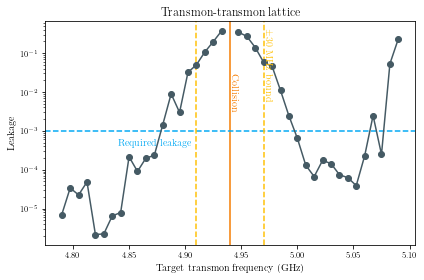

In [209]:
SAVE_IMAGE = True
LOAD_DATA = True

freq_range = 0.03
min_leakage_rate = 1e-3

if LOAD_DATA:
    lattice_type = "transmon"
    collision_type = "cross_res"
    n_photons = 1
    trans = "ctrl_12"
    da_name = f"{lattice_type}_lat_{collision_type}_col_{trans}_{n_photons}-photon_transition_scan.nc"
    
    leakage_rates = xr.load_dataarray(DATA_FOLDER / da_name)
     
with plt.rc_context(TEX_RC_PARAMS):
    fig, ax = plt.subplots(dpi=100)

    ax.axvline(
        leakage_rates.collision_cond, 
        linestyle = "-", 
        color="#f57c00"
    )
    ax.text(
        leakage_rates.collision_cond, 
        1e-2, 
        "Collision", 
        horizontalalignment="left", 
        verticalalignment="center", 
        rotation=-90, 
        color="#f57c00"
    )

    ax.axhline(min_leakage_rate, linestyle = "--", color="#03a9f4")
    ax.text(
        4.84, 
        min_leakage_rate - 5e-4, 
        "Required leakage", 
        ha="left",  va="center", 
        color="#03a9f4"
    )

    ax.axvline(leakage_rates.collision_cond - freq_range, linestyle = "--", color="#ffc107")
    ax.axvline(leakage_rates.collision_cond + freq_range, linestyle = "--", color="#ffc107")
    ax.text(
        leakage_rates.collision_cond + freq_range + 0.001, 
        5e-2, 
        f"$\pm${int(freq_range*1e3)} MHz bound", 
        ha="left", va="center", 
        rotation=-90, 
        color="#ffc107"
    )

    ax.plot(leakage_rates.target_freq, leakage_rates, linestyle="-", marker="o", color="#455a64")

    ax.set_yscale("log")
    ax.set_ylabel("Leakage")
    ax.set_xlabel("Target transmon frequency (GHz)")
    ax.set_title("Transmon-transmon lattice")

    plt.tight_layout()

    if SAVE_IMAGE:
        lattice_type = "transmon"
        collision_type = "cross_res"
        n_photons = 1
        trans = "ctrl_12"
        image_name = f"{lattice_type}_lat_{collision_type}_col_{trans}_{n_photons}-photon_transition_bounds"
        for file_format in ['pdf', 'png']:
            full_name = f"{image_name}.{file_format}"
            plt.savefig(
                IMG_FOLDER / full_name,  
                dpi=300,  
                bbox_inches='tight', 
                transparent=True, 
                format=file_format
            )
    plt.show()

In [212]:
np.array([5, 5.06, 5.12, 5.18, 5.24]) - 0.24

array([4.76, 4.82, 4.88, 4.94, 5.  ])

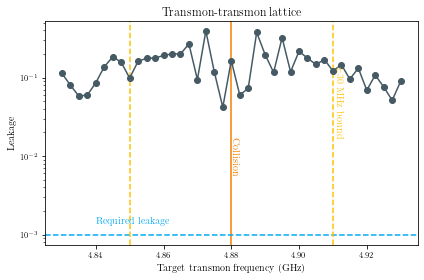

In [262]:
SAVE_IMAGE = True
LOAD_DATA = True

freq_range = 0.030
min_leakage_rate = 1e-3

if LOAD_DATA:
    lattice_type = "transmon"
    collision_type = "cross_res"
    n_photons = 1
    trans = "ctrl_12"
    da_name = f"{lattice_type}_lat_{collision_type}_col_{trans}_{n_photons}-photon_transition_scan.nc"
    
    leakage_rates = xr.load_dataarray(DATA_FOLDER / da_name)
     
with plt.rc_context(TEX_RC_PARAMS): 
    fig, ax = plt.subplots(dpi=100)

    ax.axvline(
        leakage_rates.collision_cond, 
        linestyle = "-", 
        color="#f57c00"
    )
    ax.text(
        leakage_rates.collision_cond, 
        1e-2, 
        "Collision", 
        horizontalalignment="left", 
        verticalalignment="center", 
        rotation=-90, 
        color="#f57c00"
    )

    ax.axhline(min_leakage_rate, linestyle = "--", color="#03a9f4")
    ax.text(
        4.84, 
        min_leakage_rate + 5e-4, 
        "Required leakage", 
        ha="left",  va="center", 
        color="#03a9f4"
    )

    ax.axvline(leakage_rates.collision_cond - freq_range, linestyle = "--", color="#ffc107")
    ax.axvline(leakage_rates.collision_cond + freq_range, linestyle = "--", color="#ffc107")
    ax.text(
        leakage_rates.collision_cond + freq_range + 0.001, 
        5e-2, 
        f"$\pm${int(freq_range*1e3)} MHz bound", 
        ha="left", va="center", 
        rotation=-90, 
        color="#ffc107"
    )

    ax.plot(leakage_rates.target_freq, leakage_rates, linestyle="-", marker="o", color="#455a64")

    ax.set_yscale("log")
    ax.set_ylabel("Leakage")
    ax.set_xlabel("Target transmon frequency (GHz)")
    ax.set_title("Transmon-transmon lattice")

    plt.tight_layout()

    if SAVE_IMAGE:
        lattice_type = "transmon"
        collision_type = "cross_res"
        n_photons = 1
        trans = "ctrl_12"
        image_name = f"{lattice_type}_lat_{collision_type}_col_{trans}_{n_photons}-photon_transition_bounds"
        for file_format in ['pdf', 'png']:
            full_name = f"{image_name}.{file_format}"
            plt.savefig(
                IMG_FOLDER / full_name,  
                dpi=300,  
                bbox_inches='tight', 
                transparent=True, 
                format=file_format
            )
    plt.show()

In [213]:
0.5*(10 - 0.3)

4.85

### Scan around the $f_{control}^{0 \rightarrow 2} = 2f_{target}^{0 \rightarrow 1}$ frequency collision

In [234]:
SAVE_DATA = True
FREQ_RANGE = 0.05 #GHz
NUM_POINTS = 41

collision_cond = control_transmon.freq + 0.5*control_transmon.anharm
target_freqs = np.linspace(collision_cond - FREQ_RANGE, collision_cond + FREQ_RANGE, NUM_POINTS)

results = []
comp_labels = comp_state_labels(2)

for tar_freq in target_freqs:
    target_tmon = qubits.SimpleTransmon(
        label = 'target', 
        max_freq = tar_freq, 
        anharm = TRANSMON_ANHARM,
        diel_loss_tan = DIEL_LOSS_TANGENT,
        env_thermal_energy = THERMAL_ENERGY,    
        dim_hilbert = TRANSMON_LEVELS
    )
    
    coupled_sys = target_tmon.couple_to(
        control_transmon, 
        coupling = couplers.capacitive_coupling, 
        strength=coup_strength,
    )
    
    comp_states = get_states(coupled_sys, comp_labels)
    
    drive_params = get_drive_params(
        system = coupled_sys,
        comp_states = comp_states,
        eps_drive = EPS_DRIVE,
        rise_time = RISE_TIME,
    )
    
    times =  drive_params["time"]
    coupled_sys['control'].drives['cr_drive'].set_params(**drive_params)
    
    comp_states_list = list(comp_states.values())
    
    leakage_rate = get_leakage(
        times = times,
        system = coupled_sys,
        comp_states = comp_states_list,
        options = SOLVER_OPTIONS,
        with_noise = False
    )

    results.append(leakage_rate)
    
leakage_rates = xr.DataArray(
    results,
    dims = ["target_freq"],
    coords = dict(target_freq = target_freqs),
    attrs = dict(
        control_freq = control_transmon.freq,
        anharm = TRANSMON_ANHARM,
        collision_cond = collision_cond,
        rise_time = RISE_TIME,
        eps_drive = EPS_DRIVE,
        transmon_levels = TRANSMON_LEVELS,
        points_per_drive_period = 10,
    )
)

if SAVE_DATA:
    lattice_type = "transmon"
    collision_type = "cross_res"
    n_photons = 2
    trans = "ctrl_02"
    da_name = f"{lattice_type}_lat_{collision_type}_col_{trans}_{n_photons}-photon_transition_scan.nc"
    leakage_rates.to_netcdf(DATA_FOLDER / da_name)

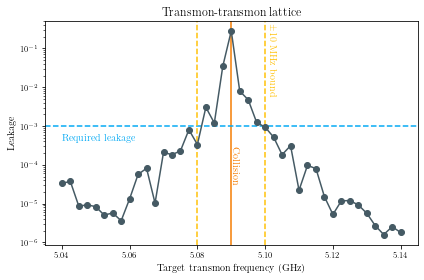

In [241]:
SAVE_IMAGE = True
LOAD_DATA = False

freq_range = 0.010
min_leakage_rate = 1e-3

if LOAD_DATA:
    lattice_type = "transmon"
    collision_type = "cross_res"
    n_photons = 2
    trans = "ctrl_02"
    da_name = f"{lattice_type}_lat_{collision_type}_col_{trans}_{n_photons}-photon_transition_scan.nc"
    
    leakage_rates = xr.load_dataarray(DATA_FOLDER / da_name)
     
with plt.rc_context(TEX_RC_PARAMS):
    fig, ax = plt.subplots(dpi=100)

    ax.axvline(
        leakage_rates.collision_cond, 
        linestyle = "-", 
        color="#f57c00"
    )
    ax.text(
        leakage_rates.collision_cond, 
        1e-4, 
        "Collision", 
        horizontalalignment="left", 
        verticalalignment="center", 
        rotation=-90, 
        color="#f57c00"
    )

    ax.axhline(min_leakage_rate, linestyle = "--", color="#03a9f4")
    ax.text(
        5.04, 
        min_leakage_rate - 5e-4, 
        "Required leakage", 
        ha="left",  va="center", 
        color="#03a9f4"
    )

    ax.axvline(leakage_rates.collision_cond - freq_range, linestyle = "--", color="#ffc107")
    ax.axvline(leakage_rates.collision_cond + freq_range, linestyle = "--", color="#ffc107")
    ax.text(
        leakage_rates.collision_cond + freq_range + 0.001, 
        5e-2, 
        f"$\pm${int(freq_range*1e3)} MHz bound", 
        ha="left", va="center", 
        rotation=-90, 
        color="#ffc107"
    )

    ax.plot(leakage_rates.target_freq, leakage_rates, linestyle="-", marker="o", color="#455a64")

    ax.set_yscale("log")
    ax.set_ylabel("Leakage")
    ax.set_xlabel("Target transmon frequency (GHz)")
    ax.set_title("Transmon-transmon lattice")

    plt.tight_layout()

    if SAVE_IMAGE:
        lattice_type = "transmon"
        collision_type = "cross_res"
        n_photons = 2
        trans = "ctrl_02"
        image_name = f"{lattice_type}_lat_{collision_type}_col_{trans}_{n_photons}-photon_transition_bounds"
        for file_format in ['pdf', 'png']:
            full_name = f"{image_name}.{file_format}"
            plt.savefig(
                IMG_FOLDER / full_name,  
                dpi=300,  
                bbox_inches='tight', 
                transparent=True, 
                format=file_format
            )
    plt.show()

# Scans with the spectator transmon frequency

### Setting up the drive parameters between the control and target

In [264]:
target_transmon = qubits.SimpleTransmon(
    label = 'target', 
    max_freq = TARGET_FREQ, 
    anharm = TRANSMON_ANHARM,
    diel_loss_tan = DIEL_LOSS_TANGENT,
    env_thermal_energy = THERMAL_ENERGY,    
    dim_hilbert = TRANSMON_LEVELS
)

coupled_sys = target_transmon.couple_to(
    control_transmon, 
    coupling = couplers.capacitive_coupling, 
    strength=coup_strength,
)

EPS_DRIVE = 0.03 #GHz
RISE_TIME = 10 #ns

comp_labels = comp_state_labels(2)
comp_states = get_states(coupled_sys, comp_labels)

drive_params = get_drive_params(
    system = coupled_sys,
    comp_states = comp_states,
    eps_drive = EPS_DRIVE,
    rise_time = RISE_TIME,
)
times =  drive_params["time"]

### Scan around the $f_{spec}^{0 \rightarrow 1} + f_{target}^{0\rightarrow 1} = f_{control}^{0\rightarrow 2}$ frequency collision

In [282]:
SAVE_DATA = True
FREQ_RANGE = 0.05 #GHz
NUM_POINTS = 41

collision_cond = 2*control_transmon.freq + control_transmon.anharm - target_transmon.freq
spectator_freqs = np.linspace(collision_cond - FREQ_RANGE, collision_cond + FREQ_RANGE, NUM_POINTS)

results = []
comp_labels = comp_state_labels(3)

for spec_freq in spectator_freqs:
    spec_transmon = qubits.SimpleTransmon(
        label = 'spectator', 
        max_freq = spec_freq, 
        anharm = TRANSMON_ANHARM,
        diel_loss_tan = DIEL_LOSS_TANGENT,
        env_thermal_energy = THERMAL_ENERGY,    
        dim_hilbert = TRANSMON_LEVELS
    )
    
    control_spectator_coup = couplers.capacitive_coupling(
        qubits=[control_transmon, spec_transmon],
        strength=coup_strength,
    )
    
    full_sys = systems.QubitSystem(
        qubits=[target_transmon, control_transmon, spec_transmon],
        coupling=[target_control_coup, control_spectator_coup]
    )
    
    full_sys['control'].drives['cr_drive'].set_params(**drive_params)
    
    comp_states = get_states(full_sys, comp_labels)
    comp_states_list = list(comp_states.values())
    
    leakage_rate = get_leakage(
        times = times,
        system = full_sys,
        comp_states = comp_states_list,
        options = SOLVER_OPTIONS,
        with_noise = False
    )
    
    results.append(leakage_rate)
    
leakage_rates = xr.DataArray(
    results,
    dims = ["spectator_freq"],
    coords = dict(spectator_freq = spectator_freqs),
    attrs = dict(
        control_freq = control_transmon.freq,
        target_freq = target_transmon.freq,
        anharm = TRANSMON_ANHARM,
        collision_cond = collision_cond,
        rise_time = RISE_TIME,
        eps_drive = EPS_DRIVE,
        pulse_time = drive_params["pulse_time"],
        drive_freq = drive_params["freq"],
        points_per_drive_period = 10,
        transmon_levels = TRANSMON_LEVELS,
    )
)

if SAVE_DATA:
    lattice_type = "transmon"
    collision_type = "spectator"
    n_photons = 2
    trans = "ctrl_02"
    da_name = f"{lattice_type}_lat_{collision_type}_col_{trans}_{n_photons}-photon_transition_scan.nc"
    leakage_rates.to_netcdf(DATA_FOLDER / da_name)

In [279]:
control_transmon.freq + TRANSMON_ANHARM

4.88

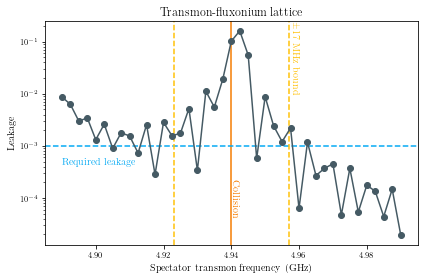

In [289]:
SAVE_IMAGE = False
LOAD_DATA = True

freq_range = 0.017
min_leakage_rate = 1e-3

if LOAD_DATA:
    lattice_type = "transmon"
    collision_type = "spectator"
    n_photons = 2
    trans = "ctrl_02"
    da_name = f"{lattice_type}_lat_{collision_type}_col_{trans}_{n_photons}-photon_transition_scan.nc"
    
    leakage_rates = xr.load_dataarray(DATA_FOLDER / da_name)
     
with plt.rc_context(TEX_RC_PARAMS):
    fig, ax = plt.subplots(dpi=200)

    ax.axvline(
        leakage_rates.collision_cond, 
        linestyle = "-", 
        color="#f57c00"
    )
    ax.text(
        leakage_rates.collision_cond, 
        1e-4, 
        "Collision", 
        horizontalalignment="left", 
        verticalalignment="center", 
        rotation=-90, 
        color="#f57c00"
    )

    ax.axhline(min_leakage_rate, linestyle = "--", color="#03a9f4")
    ax.text(
        4.89, 
        min_leakage_rate - 5e-4, 
        "Required leakage", 
        ha="left",  va="center", 
        color="#03a9f4"
    )

    ax.axvline(leakage_rates.collision_cond - freq_range, linestyle = "--", color="#ffc107")
    ax.axvline(leakage_rates.collision_cond + freq_range, linestyle = "--", color="#ffc107")
    ax.text(
        leakage_rates.collision_cond + freq_range + 1e-3, 
        5e-2, 
        f"$\pm${int(freq_range*1e3)} MHz bound", 
        ha="left", va="center", 
        rotation=-90, 
        color="#ffc107"
    )

    ax.plot(leakage_rates.spectator_freq, leakage_rates, linestyle="-", marker="o", color="#455a64")

    ax.set_yscale("log")
    ax.set_ylabel("Leakage")
    ax.set_xlabel("Spectator transmon frequency (GHz)")
    ax.set_title("Transmon-fluxonium lattice")

    plt.tight_layout()

    if SAVE_IMAGE:
        lattice_type = "transmon"
        collision_type = "spectator"
        n_photons = 2
        trans = "ctrl_02"
        image_name = f"{lattice_type}_lat_{collision_type}_col_{trans}_{n_photons}-photon_transition_bounds"
        for file_format in ['pdf', 'png']:
            full_name = f"{image_name}.{file_format}"
            plt.savefig(
                IMG_FOLDER / full_name,  
                dpi=300,  
                bbox_inches='tight', 
                transparent=True, 
                format=file_format
            )
    plt.show()

# Note: something fishy is happening on the right. Some bullshit

### Scan around the $f_{spec}^{1 \rightarrow 2} = f_{target}^{0\rightarrow 1}$ frequency collision

In [291]:
SAVE_DATA = True
FREQ_RANGE = 0.05 #GHz
NUM_POINTS = 41

collision_cond = target_transmon.freq - TRANSMON_ANHARM
spectator_freqs = np.linspace(collision_cond - FREQ_RANGE, collision_cond + FREQ_RANGE, NUM_POINTS)

results = []
comp_labels = comp_state_labels(3)

for spec_freq in spectator_freqs:
    spec_transmon = qubits.SimpleTransmon(
        label = 'spectator', 
        max_freq = spec_freq, 
        anharm = TRANSMON_ANHARM,
        diel_loss_tan = DIEL_LOSS_TANGENT,
        env_thermal_energy = THERMAL_ENERGY,    
        dim_hilbert = TRANSMON_LEVELS
    )
    
    control_spectator_coup = couplers.capacitive_coupling(
        qubits=[control_transmon, spec_transmon],
        strength=coup_strength,
    )
    
    full_sys = systems.QubitSystem(
        qubits=[target_transmon, control_transmon, spec_transmon],
        coupling=[target_control_coup, control_spectator_coup]
    )
    
    full_sys['control'].drives['cr_drive'].set_params(**drive_params)
    
    comp_states = get_states(full_sys, comp_labels)
    comp_states_list = list(comp_states.values())
    
    leakage_rate = get_leakage(
        times = times,
        system = full_sys,
        comp_states = comp_states_list,
        options = SOLVER_OPTIONS,
        with_noise = False
    )
    
    results.append(leakage_rate)
    
leakage_rates = xr.DataArray(
    results,
    dims = ["spectator_freq"],
    coords = dict(spectator_freq = spectator_freqs),
    attrs = dict(
        control_freq = control_transmon.freq,
        target_freq = target_transmon.freq,
        anharm = TRANSMON_ANHARM,
        collision_cond = collision_cond,
        rise_time = RISE_TIME,
        eps_drive = EPS_DRIVE,
        pulse_time = drive_params["pulse_time"],
        drive_freq = drive_params["freq"],
        points_per_drive_period = 10,
        transmon_levels = TRANSMON_LEVELS,
    )
)

if SAVE_DATA:
    lattice_type = "transmon"
    collision_type = "spectator"
    n_photons = 1
    trans = "spec_12"
    da_name = f"{lattice_type}_lat_{collision_type}_col_{trans}_{n_photons}-photon_transition_scan.nc"
    leakage_rates.to_netcdf(DATA_FOLDER / da_name)

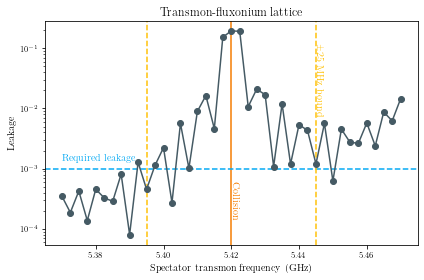

In [299]:
SAVE_IMAGE = False
LOAD_DATA = True

freq_range = 0.025
min_leakage_rate = 1e-3

if LOAD_DATA:
    lattice_type = "transmon"
    collision_type = "spectator"
    n_photons = 1
    trans = "spec_12"
    da_name = f"{lattice_type}_lat_{collision_type}_col_{trans}_{n_photons}-photon_transition_scan.nc"
    
    leakage_rates = xr.load_dataarray(DATA_FOLDER / da_name)
     
with plt.rc_context(TEX_RC_PARAMS):
    fig, ax = plt.subplots(dpi=200)

    ax.axvline(
        leakage_rates.collision_cond, 
        linestyle = "-", 
        color="#f57c00"
    )
    ax.text(
        leakage_rates.collision_cond, 
        3e-4, 
        "Collision", 
        horizontalalignment="left", 
        verticalalignment="center", 
        rotation=-90, 
        color="#f57c00"
    )

    ax.axhline(min_leakage_rate, linestyle = "--", color="#03a9f4")
    ax.text(
        5.37, 
        min_leakage_rate + 5e-4, 
        "Required leakage", 
        ha="left",  va="center", 
        color="#03a9f4"
    )

    ax.axvline(leakage_rates.collision_cond - freq_range, linestyle = "--", color="#ffc107")
    ax.axvline(leakage_rates.collision_cond + freq_range, linestyle = "--", color="#ffc107")
    ax.text(
        leakage_rates.collision_cond + freq_range, 
        3e-2, 
        f"$\pm${int(freq_range*1e3)} MHz bound", 
        ha="left", va="center", 
        rotation=-90, 
        color="#ffc107"
    )

    ax.plot(leakage_rates.spectator_freq, leakage_rates, linestyle="-", marker="o", color="#455a64")

    ax.set_yscale("log")
    ax.set_ylabel("Leakage")
    ax.set_xlabel("Spectator transmon frequency (GHz)")
    ax.set_title("Transmon-fluxonium lattice")

    plt.tight_layout()

    if SAVE_IMAGE:
        lattice_type = "transmon"
        collision_type = "spectator"
        n_photons = 1
        trans = "spec_12"
        image_name = f"{lattice_type}_lat_{collision_type}_col_{trans}_{n_photons}-photon_transition_bounds"
        for file_format in ['pdf', 'png']:
            full_name = f"{image_name}.{file_format}"
            plt.savefig(
                IMG_FOLDER / full_name,  
                dpi=300,  
                bbox_inches='tight', 
                transparent=True, 
                format=file_format
            )
    plt.show()

# Old scans with old parameters

In [301]:
spectator_freqs = np.linspace(4.6, 5.8, 61)
times = drive_params["time"]
leakage_rates = []

for spec_freq in spectator_freqs:
    spec_transmon = qubits.SimpleTransmon(
        label = 'spectator', 
        max_freq = spec_freq, 
        anharm = TRANSMON_ANHARM,
        diel_loss_tan = DIEL_LOSS_TANGENT,
        env_thermal_energy = THERMAL_ENERGY,    
        dim_hilbert = TRANSMON_LEVELS
    )
    
    control_spectator_coup = couplers.capacitive_coupling(
        qubits=[control_transmon, spec_transmon],
        strength=coup_strength,
    )
    
    full_sys = systems.QubitSystem(
        qubits=[target_transmon, control_transmon, spec_transmon],
        coupling=[target_control_coup, control_spectator_coup]
    )
    
    full_sys['control'].drives['cr_drive'].set_params(**drive_params)
    
    comp_states_dict = get_states(full_sys, comp_state_labels(3))
    comp_states = list(comp_states_dict.values())
    
    leakage_rate = get_leakage(
        times = times,
        system = full_sys,
        comp_states = comp_states,
        options = SOLVER_OPTIONS,
        with_noise = False
    )
    leakage_rates.append(leakage_rate)

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(dpi=100)

ax.scatter(spectator_freqs, leakage_rates)
#ax.axvline(4.95)
plt.show()

In [23]:
spectator_freqs = np.linspace(4.65, 5.25, 41)
times = drive_params["time"]
leakage_rates = []

for spec_freq in spectator_freqs:
    spec_transmon = qubits.SimpleTransmon(
        label = 'spectator', 
        max_freq = spec_freq, 
        anharm = TRANSMON_ANHARM,
        diel_loss_tan = DIEL_LOSS_TANGENT,
        env_thermal_energy = THERMAL_ENERGY,    
        dim_hilbert = TRANSMON_LEVELS
    )
    
    control_spectator_coup = couplers.capacitive_coupling(
        qubits=[control_transmon, spec_transmon],
        strength=coup_strength,
    )
    
    full_sys = systems.QubitSystem(
        qubits=[target_transmon, control_transmon, spec_transmon],
        coupling=[target_control_coup, control_spectator_coup]
    )
    
    full_sys['control'].drives['cr_drive'].set_params(**drive_params)
    
    comp_states_dict = get_states(full_sys, comp_state_labels(3))
    comp_states = list(comp_states_dict.values())
    
    leakage_rate = get_leakage(
        times = times,
        system = full_sys,
        comp_states = comp_states,
        options = SOLVER_OPTIONS,
        with_noise = False
    )
    leakage_rates.append(leakage_rate)

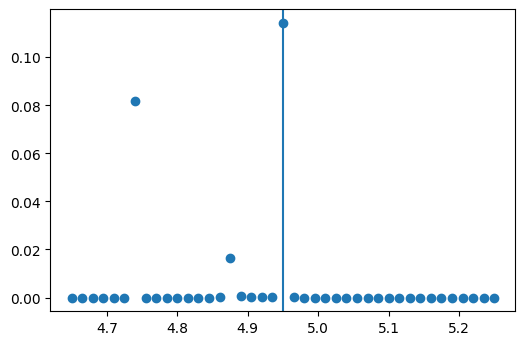

In [24]:
fig, ax = plt.subplots(dpi=100)

ax.scatter(spectator_freqs, leakage_rates)
ax.axvline(4.95)
plt.show()

### Detailed scan around the $f_{spec}^{0\rightarrow1} + f_{target}^{0\rightarrow1} = f_{control}^{0\rightarrow2}$ frequency collision

In [62]:
FREQ_RANGE = 0.05 # GHz
NUM_POINTS = 41

collision_cond = (2*control_transmon.freq + control_transmon.anharm) - target_transmon.freq
spectator_freqs = np.linspace(collision_cond - FREQ_RANGE, collision_cond + FREQ_RANGE, NUM_POINTS)

times = drive_params["time"]
leakage_rates = []

for spec_freq in spectator_freqs:
    spec_transmon = qubits.SimpleTransmon(
        label = 'spectator', 
        max_freq = spec_freq, 
        anharm = TRANSMON_ANHARM,
        diel_loss_tan = DIEL_LOSS_TANGENT,
        env_thermal_energy = THERMAL_ENERGY,    
        dim_hilbert = TRANSMON_LEVELS
    )
    
    control_spectator_coup = couplers.capacitive_coupling(
        qubits=[control_transmon, spec_transmon],
        strength=coup_strength,
    )
    
    full_sys = systems.QubitSystem(
        qubits=[target_transmon, control_transmon, spec_transmon],
        coupling=[target_control_coup, control_spectator_coup]
    )
    
    full_sys['control'].drives['cr_drive'].set_params(**drive_params)
    
    comp_states_dict = get_states(full_sys, comp_state_labels(3))
    comp_states = list(comp_states_dict.values())
    
    leakage_rate = get_leakage(
        times = times,
        system = full_sys,
        comp_states = comp_states,
        options = SOLVER_OPTIONS,
        with_noise = False
    )
    leakage_rates.append(leakage_rate)

In [103]:
leakage_arr = xr.DataArray(
    leakage_rates,
    dims = ["spectator_freq"],
    coords = dict(spectator_freq = spectator_freqs),
    attrs = dict(
        control_freq = control_transmon.freq,
        target_freq = target_transmon.freq,
        anharm = TRANSMON_ANHARM,
        pulse_time = drive_params["pulse_time"],
        rise_time = drive_params["rise_time"],
        drive_amp = drive_params["amp"], 
        drive_freq = drive_params["freq"],
        points_per_drive_period = 10
    )
)

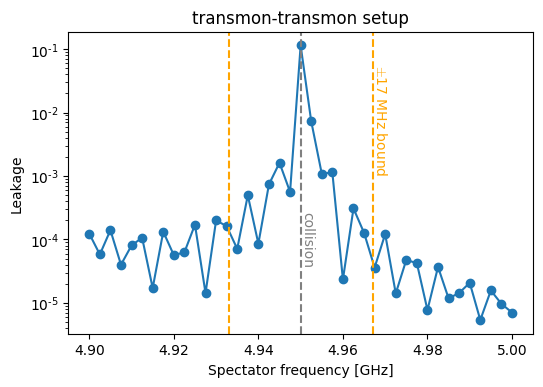

In [91]:
fig, ax = plt.subplots(dpi=100)

freq_range = 0.017

ax.plot(spectator_freqs, leakage_rates, linestyle="-", marker="o")
ax.axvline(collision_cond, linestyle = "--", color="grey")

ax.text(collision_cond, 1e-4, "collision", horizontalalignment="left", verticalalignment="center", rotation=-90, color="grey")

ax.axvline(collision_cond - freq_range, linestyle = "--", color="orange")
ax.axvline(collision_cond + freq_range, linestyle = "--", color="orange")

ax.text(collision_cond + freq_range, 0.001, r"$\pm$17 MHz bound", horizontalalignment="left", verticalalignment="bottom", rotation=-90, color="orange")

ax.set_yscale("log")
ax.set_ylabel("Leakage")
ax.set_xlabel("Spectator frequency [GHz]")
ax.set_title("transmon-transmon setup")
plt.show()

In [108]:
SAVE_DATA = True

if SAVE_DATA:
    notebook_dir = Path.cwd()
    data_folder = notebook_dir / "data"
    data_folder.mkdir(parents=True, exist_ok=True)
    
    arr_name = f"transmon_device_spectator_two_photon_control_02_collision_scan.nc"
    leakage_arr.to_netcdf(data_folder / arr_name)

### Detailed scan around the $f_{spec}^{0\rightarrow1} + f_{control}^{0\rightarrow1} = f_{target}^{0\rightarrow2}$ frequency collision

In [61]:
FREQ_RANGE = 0.05 # GHz
NUM_POINTS = 21

#collision_cond = (2*control_transmon.freq + control_transmon.anharm) - target_transmon.freq
collision_cond = 2*target_transmon.freq + TRANSMON_ANHARM - control_transmon.freq
spectator_freqs = np.linspace(collision_cond - FREQ_RANGE, collision_cond + FREQ_RANGE, NUM_POINTS)

times = drive_params["time"]
leakage_rates = []

for spec_freq in spectator_freqs:
    spec_transmon = qubits.SimpleTransmon(
        label = 'spectator', 
        max_freq = spec_freq, 
        anharm = TRANSMON_ANHARM,
        diel_loss_tan = DIEL_LOSS_TANGENT,
        env_thermal_energy = THERMAL_ENERGY,    
        dim_hilbert = TRANSMON_LEVELS
    )
    
    control_spectator_coup = couplers.capacitive_coupling(
        qubits=[control_transmon, spec_transmon],
        strength=coup_strength,
    )
    
    full_sys = systems.QubitSystem(
        qubits=[target_transmon, control_transmon, spec_transmon],
        coupling=[target_control_coup, control_spectator_coup]
    )
    
    full_sys['control'].drives['cr_drive'].set_params(**drive_params)
    
    comp_states_dict = get_states(full_sys, comp_state_labels(3))
    comp_states = list(comp_states_dict.values())
    
    leakage_rate = get_leakage(
        times = times,
        system = full_sys,
        comp_states = comp_states,
        options = SOLVER_OPTIONS,
        with_noise = False
    )
    leakage_rates.append(leakage_rate)

In [65]:
leakage_arr = xr.DataArray(
    leakage_rates,
    dims = ["spectator_freq"],
    coords = dict(spectator_freq = spectator_freqs),
    attrs = dict(
        control_freq = control_transmon.freq,
        target_freq = target_transmon.freq,
        collision_cond = collision_cond,
        anharm = TRANSMON_ANHARM,
        pulse_time = drive_params["pulse_time"],
        rise_time = drive_params["rise_time"],
        drive_amp = drive_params["amp"], 
        drive_freq = drive_params["freq"],
        points_per_drive_period = 10
    )
)

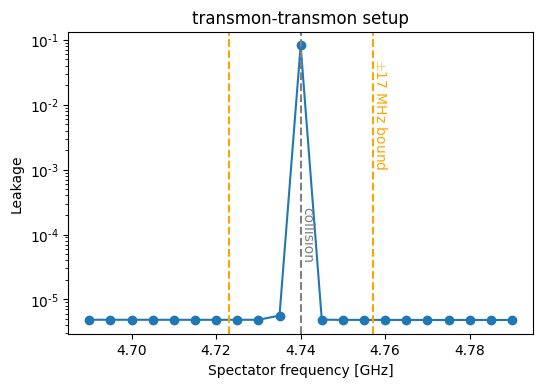

In [67]:
fig, ax = plt.subplots(dpi=100)

freq_range = 0.017

ax.plot(leakage_arr.spectator_freq, leakage_arr, linestyle="-", marker="o")
ax.axvline(leakage_arr.collision_cond, linestyle = "--", color="grey")

ax.text(leakage_arr.collision_cond, 1e-4, "collision", horizontalalignment="left", verticalalignment="center", rotation=-90, color="grey")

ax.axvline(leakage_arr.collision_cond - freq_range, linestyle = "--", color="orange")
ax.axvline(leakage_arr.collision_cond + freq_range, linestyle = "--", color="orange")

ax.text(leakage_arr.collision_cond + freq_range, 0.001, r"$\pm$17 MHz bound", horizontalalignment="left", verticalalignment="bottom", rotation=-90, color="orange")

ax.set_yscale("log")
ax.set_ylabel("Leakage")
ax.set_xlabel("Spectator frequency [GHz]")
ax.set_title("transmon-transmon setup")
plt.show()

In [68]:
SAVE_DATA = True

if SAVE_DATA:
    notebook_dir = Path.cwd()
    data_folder = notebook_dir / "data"
    data_folder.mkdir(parents=True, exist_ok=True)
    
    arr_name = f"transmon_device_spectator_two_photon_target_02_collision_scan.nc"
    leakage_arr.to_netcdf(data_folder / arr_name)

Enhance!

In [69]:
FREQ_RANGE = 0.005 # GHz
NUM_POINTS = 21

collision_cond = 2*target_transmon.freq + TRANSMON_ANHARM - control_transmon.freq
spectator_freqs = np.linspace(collision_cond - FREQ_RANGE, collision_cond + FREQ_RANGE, NUM_POINTS)

times = drive_params["time"]
leakage_rates = []

for spec_freq in spectator_freqs:
    spec_transmon = qubits.SimpleTransmon(
        label = 'spectator', 
        max_freq = spec_freq, 
        anharm = TRANSMON_ANHARM,
        diel_loss_tan = DIEL_LOSS_TANGENT,
        env_thermal_energy = THERMAL_ENERGY,    
        dim_hilbert = TRANSMON_LEVELS
    )
    
    control_spectator_coup = couplers.capacitive_coupling(
        qubits=[control_transmon, spec_transmon],
        strength=coup_strength,
    )
    
    full_sys = systems.QubitSystem(
        qubits=[target_transmon, control_transmon, spec_transmon],
        coupling=[target_control_coup, control_spectator_coup]
    )
    
    full_sys['control'].drives['cr_drive'].set_params(**drive_params)
    
    comp_states_dict = get_states(full_sys, comp_state_labels(3))
    comp_states = list(comp_states_dict.values())
    
    leakage_rate = get_leakage(
        times = times,
        system = full_sys,
        comp_states = comp_states,
        options = SOLVER_OPTIONS,
        with_noise = False
    )
    leakage_rates.append(leakage_rate)

In [70]:
detailed_leakage_arr = xr.DataArray(
    leakage_rates,
    dims = ["spectator_freq"],
    coords = dict(spectator_freq = spectator_freqs),
    attrs = dict(
        control_freq = control_transmon.freq,
        target_freq = target_transmon.freq,
        collision_cond = collision_cond,
        anharm = TRANSMON_ANHARM,
        pulse_time = drive_params["pulse_time"],
        rise_time = drive_params["rise_time"],
        drive_amp = drive_params["amp"], 
        drive_freq = drive_params["freq"],
        points_per_drive_period = 10
    )
)

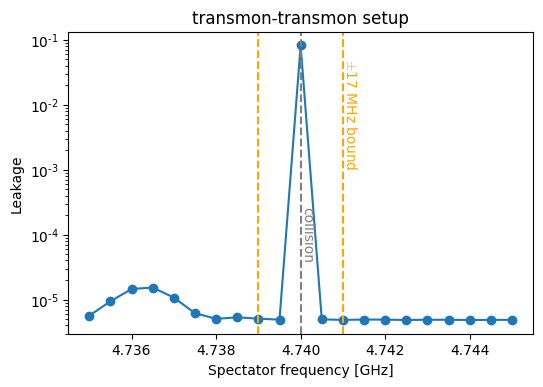

In [71]:
fig, ax = plt.subplots(dpi=100)

freq_range = 0.001

ax.plot(detailed_leakage_arr.spectator_freq, detailed_leakage_arr, linestyle="-", marker="o")
ax.axvline(detailed_leakage_arr.collision_cond, linestyle = "--", color="grey")

ax.text(detailed_leakage_arr.collision_cond, 1e-4, "collision", horizontalalignment="left", verticalalignment="center", rotation=-90, color="grey")

ax.axvline(detailed_leakage_arr.collision_cond - freq_range, linestyle = "--", color="orange")
ax.axvline(detailed_leakage_arr.collision_cond + freq_range, linestyle = "--", color="orange")

ax.text(detailed_leakage_arr.collision_cond + freq_range, 0.001, r"$\pm$17 MHz bound", horizontalalignment="left", verticalalignment="bottom", rotation=-90, color="orange")

ax.set_yscale("log")
ax.set_ylabel("Leakage")
ax.set_xlabel("Spectator frequency [GHz]")
ax.set_title("transmon-transmon setup")
plt.show()

In [72]:
SAVE_DATA = True

if SAVE_DATA:
    notebook_dir = Path.cwd()
    data_folder = notebook_dir / "data"
    data_folder.mkdir(parents=True, exist_ok=True)
    
    arr_name = f"transmon_device_spectator_two_photon_target_02_collision_detailed_scan.nc"
    detailed_leakage_arr.to_netcdf(data_folder / arr_name)

### Detailed scan around the $f_{spec}^{1 \rightarrow 2} = f_{target}^{0\rightarrow1}$ frequency collision

In [125]:
FREQ_RANGE = 0.05 # GHz
NUM_POINTS = 41

collision_cond = target_transmon.freq - TRANSMON_ANHARM
spectator_freqs = np.linspace(collision_cond - FREQ_RANGE, collision_cond + FREQ_RANGE, NUM_POINTS)

times = drive_params["time"]
leakage_rates = []

for spec_freq in spectator_freqs:
    spec_transmon = qubits.SimpleTransmon(
        label = 'spectator', 
        max_freq = spec_freq, 
        anharm = TRANSMON_ANHARM,
        diel_loss_tan = DIEL_LOSS_TANGENT,
        env_thermal_energy = THERMAL_ENERGY,    
        dim_hilbert = TRANSMON_LEVELS
    )
    
    control_spectator_coup = couplers.capacitive_coupling(
        qubits=[control_transmon, spec_transmon],
        strength=coup_strength,
    )
    
    full_sys = systems.QubitSystem(
        qubits=[target_transmon, control_transmon, spec_transmon],
        coupling=[target_control_coup, control_spectator_coup]
    )
    
    full_sys['control'].drives['cr_drive'].set_params(**drive_params)
    
    comp_states_dict = get_states(full_sys, comp_state_labels(3))
    comp_states = list(comp_states_dict.values())
    
    leakage_rate = get_leakage(
        times = times,
        system = full_sys,
        comp_states = comp_states,
        options = SOLVER_OPTIONS,
        with_noise = False
    )
    leakage_rates.append(leakage_rate)

In [131]:
leakage_arr = xr.DataArray(
    leakage_rates,
    dims = ["spectator_freq"],
    coords = dict(spectator_freq = spectator_freqs),
    attrs = dict(
        control_freq = control_transmon.freq,
        target_freq = target_transmon.freq,
        collision_cond = collision_cond,
        anharm = TRANSMON_ANHARM,
        pulse_time = drive_params["pulse_time"],
        rise_time = drive_params["rise_time"],
        drive_amp = drive_params["amp"], 
        drive_freq = drive_params["freq"],
        points_per_drive_period = 10
    )
)

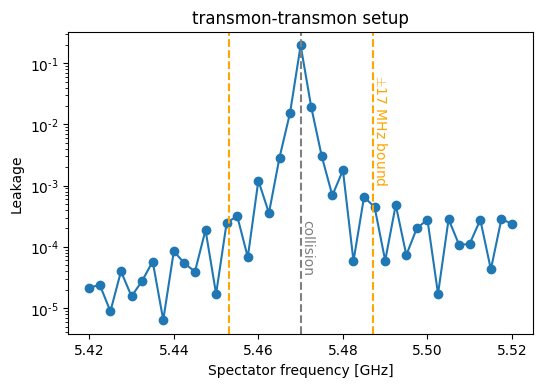

In [133]:
fig, ax = plt.subplots(dpi=100)

freq_range = 0.017

ax.plot(leakage_arr.spectator_freq, leakage_arr, linestyle="-", marker="o")
ax.axvline(leakage_arr.collision_cond, linestyle = "--", color="grey")

ax.text(leakage_arr.collision_cond, 1e-4, "collision", horizontalalignment="left", verticalalignment="center", rotation=-90, color="grey")

ax.axvline(leakage_arr.collision_cond - freq_range, linestyle = "--", color="orange")
ax.axvline(leakage_arr.collision_cond + freq_range, linestyle = "--", color="orange")

ax.text(leakage_arr.collision_cond + freq_range, 0.001, r"$\pm$17 MHz bound", horizontalalignment="left", verticalalignment="bottom", rotation=-90, color="orange")

ax.set_yscale("log")
ax.set_ylabel("Leakage")
ax.set_xlabel("Spectator frequency [GHz]")
ax.set_title("transmon-transmon setup")
plt.show()

In [134]:
SAVE_DATA = True

if SAVE_DATA:
    notebook_dir = Path.cwd()
    data_folder = notebook_dir / "data"
    data_folder.mkdir(parents=True, exist_ok=True)
    
    arr_name = f"transmon_device_single_photon_spectator_12_collision_scan.nc"
    leakage_arr.to_netcdf(data_folder / arr_name)

### Detailed scan around the $f_{spec}^{0 \rightarrow 2} = 2f_{target}^{0\rightarrow1}$ frequency collision

In [136]:
FREQ_RANGE = 0.05 # GHz
NUM_POINTS = 41

collision_cond = target_transmon.freq - (0.5*TRANSMON_ANHARM)
spectator_freqs = np.linspace(collision_cond - FREQ_RANGE, collision_cond + FREQ_RANGE, NUM_POINTS)

times = drive_params["time"]
leakage_rates = []

for spec_freq in spectator_freqs:
    spec_transmon = qubits.SimpleTransmon(
        label = 'spectator', 
        max_freq = spec_freq, 
        anharm = TRANSMON_ANHARM,
        diel_loss_tan = DIEL_LOSS_TANGENT,
        env_thermal_energy = THERMAL_ENERGY,    
        dim_hilbert = TRANSMON_LEVELS
    )
    
    control_spectator_coup = couplers.capacitive_coupling(
        qubits=[control_transmon, spec_transmon],
        strength=coup_strength,
    )
    
    full_sys = systems.QubitSystem(
        qubits=[target_transmon, control_transmon, spec_transmon],
        coupling=[target_control_coup, control_spectator_coup]
    )
    
    full_sys['control'].drives['cr_drive'].set_params(**drive_params)
    
    comp_states_dict = get_states(full_sys, comp_state_labels(3))
    comp_states = list(comp_states_dict.values())
    
    leakage_rate = get_leakage(
        times = times,
        system = full_sys,
        comp_states = comp_states,
        options = SOLVER_OPTIONS,
        with_noise = False
    )
    leakage_rates.append(leakage_rate)

In [137]:
leakage_arr = xr.DataArray(
    leakage_rates,
    dims = ["spectator_freq"],
    coords = dict(spectator_freq = spectator_freqs),
    attrs = dict(
        control_freq = control_transmon.freq,
        target_freq = target_transmon.freq,
        collision_cond = collision_cond,
        anharm = TRANSMON_ANHARM,
        pulse_time = drive_params["pulse_time"],
        rise_time = drive_params["rise_time"],
        drive_amp = drive_params["amp"], 
        drive_freq = drive_params["freq"],
        points_per_drive_period = 10
    )
)

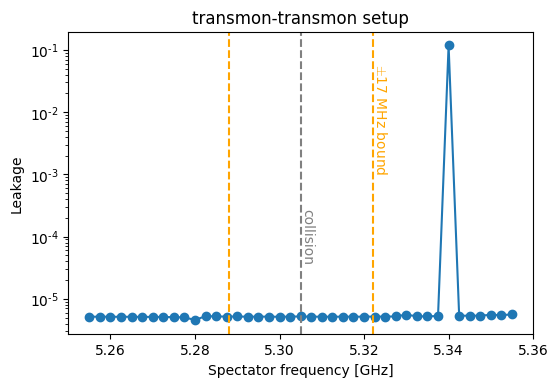

In [138]:
fig, ax = plt.subplots(dpi=100)

freq_range = 0.017

ax.plot(leakage_arr.spectator_freq, leakage_arr, linestyle="-", marker="o")
ax.axvline(leakage_arr.collision_cond, linestyle = "--", color="grey")

ax.text(leakage_arr.collision_cond, 1e-4, "collision", horizontalalignment="left", verticalalignment="center", rotation=-90, color="grey")

ax.axvline(leakage_arr.collision_cond - freq_range, linestyle = "--", color="orange")
ax.axvline(leakage_arr.collision_cond + freq_range, linestyle = "--", color="orange")

ax.text(leakage_arr.collision_cond + freq_range, 0.001, r"$\pm$17 MHz bound", horizontalalignment="left", verticalalignment="bottom", rotation=-90, color="orange")

ax.set_yscale("log")
ax.set_ylabel("Leakage")
ax.set_xlabel("Spectator frequency [GHz]")
ax.set_title("transmon-transmon setup")
plt.show()

In [149]:
FREQ_RANGE = 0.05 # GHz
NUM_POINTS = 41

collision_cond = 0.5*(target_transmon.freq + control_transmon.freq - TRANSMON_ANHARM)
spectator_freqs = np.linspace(collision_cond - FREQ_RANGE, collision_cond + FREQ_RANGE, NUM_POINTS)

times = drive_params["time"]
leakage_rates = []

for spec_freq in spectator_freqs:
    spec_transmon = qubits.SimpleTransmon(
        label = 'spectator', 
        max_freq = spec_freq, 
        anharm = TRANSMON_ANHARM,
        diel_loss_tan = DIEL_LOSS_TANGENT,
        env_thermal_energy = THERMAL_ENERGY,    
        dim_hilbert = TRANSMON_LEVELS
    )
    
    control_spectator_coup = couplers.capacitive_coupling(
        qubits=[control_transmon, spec_transmon],
        strength=coup_strength,
    )
    
    full_sys = systems.QubitSystem(
        qubits=[target_transmon, control_transmon, spec_transmon],
        coupling=[target_control_coup, control_spectator_coup]
    )
    
    full_sys['control'].drives['cr_drive'].set_params(**drive_params)
    
    comp_states_dict = get_states(full_sys, comp_state_labels(3))
    comp_states = list(comp_states_dict.values())
    
    leakage_rate = get_leakage(
        times = times,
        system = full_sys,
        comp_states = comp_states,
        options = SOLVER_OPTIONS,
        with_noise = False
    )
    leakage_rates.append(leakage_rate)

In [150]:
leakage_arr = xr.DataArray(
    leakage_rates,
    dims = ["spectator_freq"],
    coords = dict(spectator_freq = spectator_freqs),
    attrs = dict(
        control_freq = control_transmon.freq,
        target_freq = target_transmon.freq,
        collision_cond = collision_cond,
        anharm = TRANSMON_ANHARM,
        pulse_time = drive_params["pulse_time"],
        rise_time = drive_params["rise_time"],
        drive_amp = drive_params["amp"], 
        drive_freq = drive_params["freq"],
        points_per_drive_period = 10
    )
)

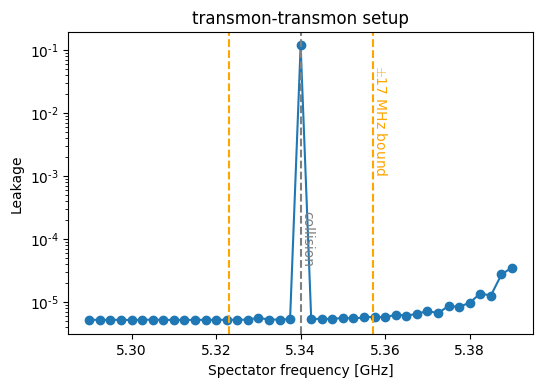

In [151]:
fig, ax = plt.subplots(dpi=100)

freq_range = 0.017

ax.plot(leakage_arr.spectator_freq, leakage_arr, linestyle="-", marker="o")
ax.axvline(leakage_arr.collision_cond, linestyle = "--", color="grey")

ax.text(leakage_arr.collision_cond, 1e-4, "collision", horizontalalignment="left", verticalalignment="center", rotation=-90, color="grey")

ax.axvline(leakage_arr.collision_cond - freq_range, linestyle = "--", color="orange")
ax.axvline(leakage_arr.collision_cond + freq_range, linestyle = "--", color="orange")

ax.text(leakage_arr.collision_cond + freq_range, 0.001, r"$\pm$17 MHz bound", horizontalalignment="left", verticalalignment="bottom", rotation=-90, color="orange")

ax.set_yscale("log")
ax.set_ylabel("Leakage")
ax.set_xlabel("Spectator frequency [GHz]")
ax.set_title("transmon-transmon setup")
plt.show()

In [161]:
SAVE_DATA = True

if SAVE_DATA:
    notebook_dir = Path.cwd()
    data_folder = notebook_dir / "data"
    data_folder.mkdir(parents=True, exist_ok=True)
    
    arr_name = f"transmon_device_spectator_two_photon_spectator_02_collision_scan.nc"
    leakage_arr.to_netcdf(data_folder / arr_name)

ENHANCE!

In [152]:
FREQ_RANGE = 0.005 # GHz
NUM_POINTS = 21

collision_cond = 0.5*(target_transmon.freq + control_transmon.freq - TRANSMON_ANHARM)
spectator_freqs = np.linspace(collision_cond - FREQ_RANGE, collision_cond + FREQ_RANGE, NUM_POINTS)

times = drive_params["time"]
leakage_rates = []

for spec_freq in spectator_freqs:
    spec_transmon = qubits.SimpleTransmon(
        label = 'spectator', 
        max_freq = spec_freq, 
        anharm = TRANSMON_ANHARM,
        diel_loss_tan = DIEL_LOSS_TANGENT,
        env_thermal_energy = THERMAL_ENERGY,    
        dim_hilbert = TRANSMON_LEVELS
    )
    
    control_spectator_coup = couplers.capacitive_coupling(
        qubits=[control_transmon, spec_transmon],
        strength=coup_strength,
    )
    
    full_sys = systems.QubitSystem(
        qubits=[target_transmon, control_transmon, spec_transmon],
        coupling=[target_control_coup, control_spectator_coup]
    )
    
    full_sys['control'].drives['cr_drive'].set_params(**drive_params)
    
    comp_states_dict = get_states(full_sys, comp_state_labels(3))
    comp_states = list(comp_states_dict.values())
    
    leakage_rate = get_leakage(
        times = times,
        system = full_sys,
        comp_states = comp_states,
        options = SOLVER_OPTIONS,
        with_noise = False
    )
    leakage_rates.append(leakage_rate)

In [153]:
detailed_leakage_arr = xr.DataArray(
    leakage_rates,
    dims = ["spectator_freq"],
    coords = dict(spectator_freq = spectator_freqs),
    attrs = dict(
        control_freq = control_transmon.freq,
        target_freq = target_transmon.freq,
        collision_cond = collision_cond,
        anharm = TRANSMON_ANHARM,
        pulse_time = drive_params["pulse_time"],
        rise_time = drive_params["rise_time"],
        drive_amp = drive_params["amp"], 
        drive_freq = drive_params["freq"],
        points_per_drive_period = 10
    )
)

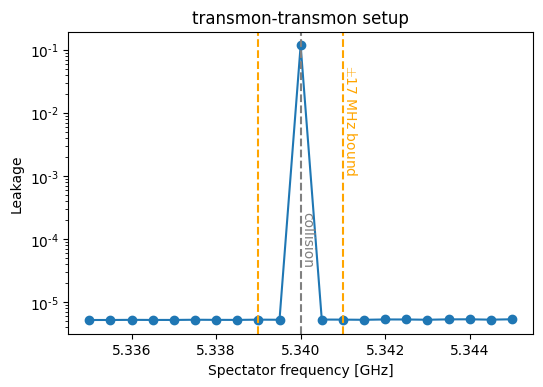

In [157]:
fig, ax = plt.subplots(dpi=100)

freq_range = 0.001

ax.plot(detailed_leakage_arr.spectator_freq, detailed_leakage_arr, linestyle="-", marker="o")
ax.axvline(detailed_leakage_arr.collision_cond, linestyle = "--", color="grey")

ax.text(detailed_leakage_arr.collision_cond, 1e-4, "collision", horizontalalignment="left", verticalalignment="center", rotation=-90, color="grey")

ax.axvline(detailed_leakage_arr.collision_cond - freq_range, linestyle = "--", color="orange")
ax.axvline(detailed_leakage_arr.collision_cond + freq_range, linestyle = "--", color="orange")

ax.text(detailed_leakage_arr.collision_cond + freq_range, 0.001, r"$\pm$17 MHz bound", horizontalalignment="left", verticalalignment="bottom", rotation=-90, color="orange")

ax.set_yscale("log")
ax.set_ylabel("Leakage")
ax.set_xlabel("Spectator frequency [GHz]")
ax.set_title("transmon-transmon setup")
plt.show()

In [162]:
SAVE_DATA = True

if SAVE_DATA:
    notebook_dir = Path.cwd()
    data_folder = notebook_dir / "data"
    data_folder.mkdir(parents=True, exist_ok=True)
    
    arr_name = f"transmon_device_spectator_two_photon_spectator_02_collision_detailed_scan.nc"
    detailed_leakage_arr.to_netcdf(data_folder / arr_name)